<!--NOTEBOOK_HEADER-->
*This notebook contains material from [cbe-virtual-laboratory](https://jckantor.github.io/cbe-virtual-laboratory);
content is available [on Github](https://github.com/jckantor/cbe-virtual-laboratory.git).*


<!--NAVIGATION-->
< [3.1 Publishing an Experiment via MQTT](https://jckantor.github.io/cbe-virtual-laboratory/03.01-Publishing_an_Experiment_via_MQTT.html) | [Contents](toc.html) | [3.3 Accessing MQTT Devices](https://jckantor.github.io/cbe-virtual-laboratory/03.03-Miscellaneous_Notes.html) ><p><a href="https://colab.research.google.com/github/jckantor/cbe-virtual-laboratory/blob/master/docs/03.02-Accessing_a_Remote_Experiment_via_MQTT.ipynb"> <img align="left" src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open in Colab" title="Open in Google Colaboratory"></a><p><a href="https://jckantor.github.io/cbe-virtual-laboratory/03.02-Accessing_a_Remote_Experiment_via_MQTT.ipynb"> <img align="left" src="https://img.shields.io/badge/Github-Download-blue.svg" alt="Download" title="Download Notebook"></a>

# 3.2 Accessing a Remote Experiment via MQTT

## 3.2.1 Installations

In [1]:
!pip install paho-mqtt

## 3.2.2 Remote Operation of a Laboratory Experiment

This cell establishes a connection to two topics on an MQTT server. The 'command' channel is used to publish a message to start a remote experiment for a duration given in seconds. A client is opened to listen to a 'measurement' channel.

Before running this channel, start up up the companion notebook that simulates a remote experiment https://colab.research.google.com/drive/1cj9Y8IlVX2-ZMEMoVWi8G5WDKNr3gkr9?usp=sharing 

In [147]:
%matplotlib inline
import paho.mqtt.client as mqtt
import paho.mqtt.publish as publish
import time
import matplotlib.pyplot as plt
import numpy as np
from IPython import display
import json
import uuid

# configuration
duration = 10

# set up client to interact with cbe-virtual-laboratory

class CBEClient(mqtt.Client):
    
    def __init__(self, recv="", send=""):
        super().__init__()
        self.host = "mqtt.eclipse.org"
        self.recv = recv
        self.send = send

    def on_connect(self, client, userdata, flags, rc):
        print(f"Connected: {self.host} with return code {rc}")
        if self.recv:
            self.subscribe(self.recv, qos=2)
            print(f"Subscribed: {self.recv}")
        
    def on_message(self, client, userdata, msg):
        payload = json.loads(msg.payload.decode("utf-8"))
        print(f"Receieved: {payload} from {self.recv}")
    
    def connect(self):
        super().connect(host=self.host, port=1883, keepalive=60)
                              
    def publish(self, payload):
        if self.send:
            super().publish(self.send, payload=payload)
            print(f"Sent: {payload} to {self.send}")
        else:
            print("No send topic has been specified.")
        
    def __enter__(self):
        self.connect()
        self.loop_start()
        time.sleep(0.5)
        print(f"Loop Started: {self}")
        return self
        
    def __exit__(self, exc_type, exc_value, exc_traceback):
        self.loop_stop()
        print(f"Loop Stopped: {self}")

# listen for response
with CBEClient(send="cbe-virtual-laboratory/command") as cbe:
    payload = {
        "client_id" : str(uuid.getnode()),
        "duration" : duration
    }
    cbe.publish(json.dumps(payload))
    with CBEClient(recv="/".join(["cbe-virtual-laboratory", payload["client_id"]])) as expt:
        time.sleep(duration)
    

Connected: mqtt.eclipse.org with return code 0
Loop Started: <__main__.CBEClient object at 0x7ffb0c31fc50>
Sent: {"client_id": "64844672765268", "duration": 10} to cbe-virtual-laboratory/command
Connected: mqtt.eclipse.org with return code 0
Subscribed: cbe-virtual-laboratory/64844672765268
Loop Started: <__main__.CBEClient object at 0x7ffb0c2ef510>
Receieved: {'time': 0, 'x': 0, 'y': 0} from cbe-virtual-laboratory/64844672765268
Receieved: {'time': 1, 'x': 0, 'y': 0} from cbe-virtual-laboratory/64844672765268
Receieved: {'time': 2, 'x': 0, 'y': 0} from cbe-virtual-laboratory/64844672765268
Receieved: {'time': 3, 'x': 0, 'y': 0} from cbe-virtual-laboratory/64844672765268
Receieved: {'time': 4, 'x': 0, 'y': 0} from cbe-virtual-laboratory/64844672765268
Receieved: {'time': 5, 'x': 0, 'y': 0} from cbe-virtual-laboratory/64844672765268
Receieved: {'time': 6, 'x': 0, 'y': 0} from cbe-virtual-laboratory/64844672765268
Receieved: {'time': 7, 'x': 0, 'y': 0} from cbe-virtual-laboratory/6484467

## 3.2.3 Version 1

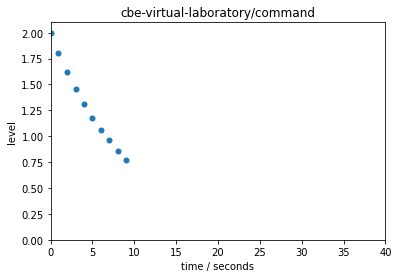

In [113]:
%matplotlib inline
import paho.mqtt.client as mqtt
import paho.mqtt.publish as publish
import time
import matplotlib.pyplot as plt
import numpy as np
from IPython import display

# select experiment duration
duration = 10
topic = "cbe-virtual-laboratory/command"

# setup a plotting window
x = []
y = []
fig, ax = plt.subplots(1, 1)
ax.plot(x, y, '.', ms=10)
ax.set_xlim(0, 40)
ax.set_ylim(0, 2.1)
ax.set_xlabel('time / seconds')
ax.set_ylabel('level')
ax.set_title(topic)
line = ax.lines[0]
display.display(fig)

# callbacks
def on_connect(client, userdata, flags, rc):
    print(f"Connected with result code {rc}")
    client.subscribe("cbe-virtual-laboratory/expt")

# call back to process message from remote experiment
def on_message(client, userdata, msg):
    #print(msg.topic + " " + msg.payload.decode("utf-8"))
    xdata, ydata = [float(i) for i in msg.payload.decode("utf-8").split(',')]
    x.append(xdata)
    y.append(ydata)
    line.set_data(x, y)
    display.clear_output(wait=True)
    display.display(fig)

# setup client
client = mqtt.Client()
client.on_connect = on_connect
client.on_message = on_message

# connect to measurement channel
client.connect("mqtt.eclipse.org", 1883, 60)

# tell experiment to start
msg = f'{{"duration": {duration}}}'
publish.single("cbe-virtual-laboratory/command", msg, hostname="mqtt.eclipse.org")

# listen for measurement information
client.loop_start()
time.sleep(duration)
client.loop_stop()

# prevent the plot showing again after completion
plt.close()

<!--NAVIGATION-->
< [3.1 Publishing an Experiment via MQTT](https://jckantor.github.io/cbe-virtual-laboratory/03.01-Publishing_an_Experiment_via_MQTT.html) | [Contents](toc.html) | [3.3 Accessing MQTT Devices](https://jckantor.github.io/cbe-virtual-laboratory/03.03-Miscellaneous_Notes.html) ><p><a href="https://colab.research.google.com/github/jckantor/cbe-virtual-laboratory/blob/master/docs/03.02-Accessing_a_Remote_Experiment_via_MQTT.ipynb"> <img align="left" src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open in Colab" title="Open in Google Colaboratory"></a><p><a href="https://jckantor.github.io/cbe-virtual-laboratory/03.02-Accessing_a_Remote_Experiment_via_MQTT.ipynb"> <img align="left" src="https://img.shields.io/badge/Github-Download-blue.svg" alt="Download" title="Download Notebook"></a>